## Key Points
- In this notebook, we will implement linear regression based artifact removal method to remove ocular artifacts from simulated EEG data. 
- from calibration run, we predicted contaminated eeg coefficients from eog data and then for testing phase we subtracted the contaminated eeg from recorded eeg. The contaminated eeg was found by multiplying the new eog with calibrated contamination coeffs (betas)
- ***close plotting window by escape bar and don't close it manually otherwise mne crashes, jupyter lab seems to be better in notebook for plotting***
- Four class motor imagery (001-2014) data set 2a of the BCI Competition IV. http://bnci-horizon-2020.eu/database/data-sets
- simulated eeg eog dataset link https://data.mendeley.com/datasets/wb6yvr725d/4
- scipy's loadmat is much faster than mat4py's loadmat (about 10 times or more)

In [1]:
import numpy as np
from scipy import io
import mne
import mat4py
import os

In [2]:
%matplotlib

Using matplotlib backend: Qt5Agg


### SNR Formula
                SNR = 20 log10 (p_estimated / p_estimated-p_True)

In [3]:
def SNR(signal, noise):
    return 20 * np.log10(np.mean(signal**2) / np.mean(noise**2))

### Loading Dataset and Preprocessing it according to MNE-Python Format

In [5]:
# file paths of data related files
dataset_path = r"semi-simulated EEG-EOG dataset"
fpath_eeg_contam = os.path.join(dataset_path, "Contaminated_Data.mat")
fpath_eeg_pure   = os.path.join(dataset_path, "Pure_Data.mat") 
fpath_veog       = os.path.join(dataset_path, "VEOG.mat") 
fpath_heog       = os.path.join(dataset_path, "HEOG.mat") 

In [15]:
mat_eeg_contam = io.loadmat(fpath_eeg_contam)
mat_eeg_pure   = io.loadmat(fpath_eeg_pure)
mat_veog       = io.loadmat(fpath_veog)
mat_heog       = io.loadmat(fpath_heog)

In [16]:
# track keys (simulation run name), first 3 are just metadata dunder keys so ignore them 
keys_eeg_contam = list(mat_eeg_contam.keys())[3:]
keys_eeg_pure   = list(mat_eeg_pure.keys())[3:]
keys_veog       = list(mat_veog.keys())[3:]
keys_heog       = list(mat_heog.keys())[3:]

In [17]:
# multiply by 10^-6 to convert readings from microvolts to volts
id = 15  # session/run/dataset id
array_eeg_contam = mat_eeg_contam[keys_eeg_contam[id]] * 1e-6
array_veog       = mat_veog[keys_veog[id]] * 1e-6
array_heog       = mat_heog[keys_heog[id]] * 1e-6
array_eeg_pure   = mat_eeg_pure[keys_eeg_pure[id]] * 1e-6

In [18]:
# combining eeg and eog in single raw data for plotting/visualization convenience
array_eeg_eog_contam = np.concatenate((array_eeg_contam, array_veog, array_heog))
array_eeg_eog_pure   = np.concatenate((array_eeg_pure,   array_veog, array_heog))

In [19]:
# already in channels first convention according to MNE format
array_eeg_eog_contam.shape, array_eeg_eog_pure.shape

((21, 6001), (21, 6001))

In [20]:
ch_names = ['FP1', 'FP2','F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
           'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'VEOG', 'HEOG']
info = mne.create_info(ch_names, sfreq=200, ch_types=["eeg"]*19 + ["eog"]*2)

In [21]:
raw_eeg_eog_contam = mne.io.RawArray(array_eeg_eog_contam, info)
raw_eeg_eog_pure   = mne.io.RawArray(array_eeg_eog_pure, info)

Creating RawArray with float64 data, n_channels=21, n_times=6001
    Range : 0 ... 6000 =      0.000 ...    30.000 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=6001
    Range : 0 ... 6000 =      0.000 ...    30.000 secs
Ready.


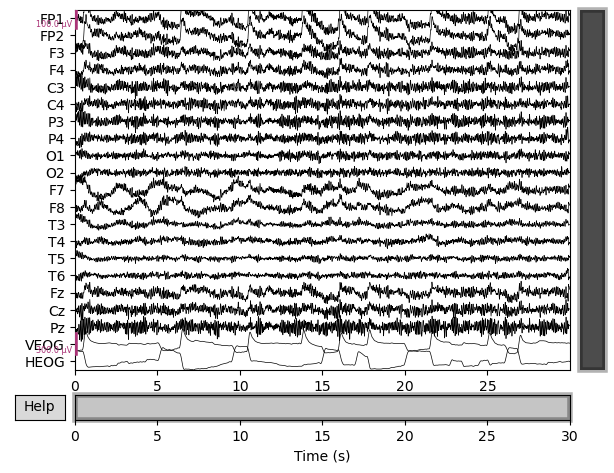

Channels marked as bad: none


In [22]:
raw_eeg_eog_contam.plot(n_channels=len(ch_names), title='Contaminated Data', 
                        duration=30, scalings=dict(eeg=50e-6, eog=150e-6))

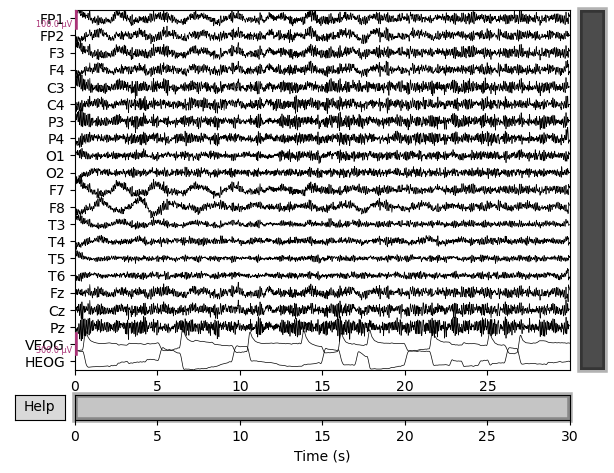

Channels marked as bad: none


In [23]:
raw_eeg_eog_pure.plot(n_channels=len(ch_names), title = "Pure Data", 
                        duration=30, scalings=dict(eeg=50e-6, eog=150e-6))

## Applying the Linear Regression Algo

### With MNE
using mne's regression function is giving better results

In [24]:
raw_eeg_eog_corrected_mne, betas_mne = mne.preprocessing.regress_artifact(raw_eeg_eog_contam)

array_eeg_corrected_mne = raw_eeg_eog_corrected_mne['eeg'][0]

SNR_contam    = SNR(array_eeg_contam, array_eeg_contam - array_eeg_pure)
SNR_corrected = SNR(array_eeg_corrected_mne, array_eeg_corrected_mne - array_eeg_pure)
print("SNR of Contaminated Signal: ", SNR_contam, "dB")
print("SNR of Corrected    Signal: ", SNR_corrected, "dB")

SNR of Contaminated Signal:  7.3214832964430085 dB
SNR of Corrected    Signal:  44.41493039443047 dB


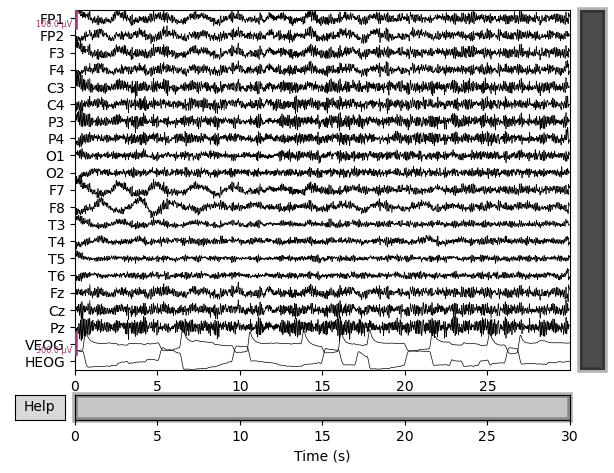

Channels marked as bad: none


In [25]:
raw_eeg_eog_corrected_mne.plot(n_channels=len(ch_names), title='MNE Corrected Data', 
                        duration=30, scalings=dict(eeg=50e-6, eog=150e-6))

### Manually Written One
Computing betas in matrix form improved the results

In [26]:
array_eog = np.concatenate((array_veog, array_heog))
betas = np.linalg.inv(array_eog @ array_eog.T) @ array_eog @ array_eeg_contam.T
array_eeg_corrected = (array_eeg_contam.T - (array_eog.T @ betas)).T

print("SNR of Contaminated Signal: ", SNR(array_eeg_contam, array_eeg_contam - array_eeg_pure), "dB")
print("SNR of Corrected    Signal: ", SNR(array_eeg_corrected, array_eeg_corrected - array_eeg_pure), "dB")

SNR of Contaminated Signal:  7.3214832964430085 dB
SNR of Corrected    Signal:  44.73170254772732 dB


In [27]:
raw_eeg_eog_corrected = raw_eeg_eog_contam.copy()
raw_eeg_eog_corrected._data[:-2] = array_eeg_corrected

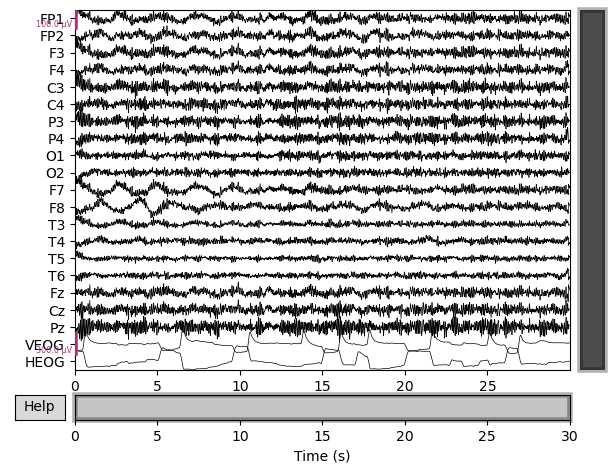

Channels marked as bad: none


In [28]:
raw_eeg_eog_corrected.plot(n_channels=len(ch_names), title='Corrected Data', 
                        duration=30, scalings=dict(eeg=50e-6, eog=150e-6))

### Joint Plots for Comparison

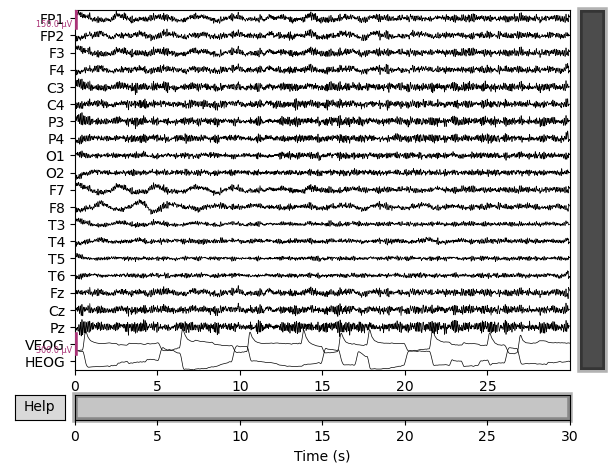

Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none


In [29]:
raw_eeg_eog_contam.plot(n_channels=len(ch_names), title='Contaminated Data', 
                        duration=30, scalings=dict(eeg=75e-6, eog=150e-6))

raw_eeg_eog_pure.plot(n_channels=len(ch_names), title = "Pure Data", 
                        duration=30, scalings=dict(eeg=75e-6, eog=150e-6))

raw_eeg_eog_corrected.plot(n_channels=len(ch_names), title='Customly Corrected Data', 
                        duration=30, scalings=dict(eeg=75e-6, eog=150e-6))

raw_eeg_eog_corrected_mne.plot(n_channels=len(ch_names), title='MNE Corrected Data', 
                        duration=30, scalings=dict(eeg=75e-6, eog=150e-6))

## For all 54 runs
we don't need to convert to mne format and can directly deal with arrays

### Custom Regressor with Matrix Form Betas

In [30]:
snr_contam_list = []
snr_corrected_list = []

for idx in range(54):  # to evaluate across 54 sessions  
    array_eeg_contam = mat_eeg_contam[keys_eeg_contam[idx]] * 1e-6
    array_veog       = mat_veog[keys_veog[idx]] * 1e-6
    array_heog       = mat_heog[keys_heog[idx]] * 1e-6
    array_eeg_pure   = mat_eeg_pure[keys_eeg_pure[idx]] * 1e-6

    array_eog = np.concatenate((array_veog, array_heog))
    betas = np.linalg.inv(array_eog @ array_eog.T) @ array_eog @ array_eeg_contam.T
    array_eeg_corrected = (array_eeg_contam.T - (array_eog.T @ betas)).T

    snr_contam_list.append(SNR(array_eeg_contam, array_eeg_contam - array_eeg_pure))
    snr_corrected_list.append(SNR(array_eeg_corrected, array_eeg_corrected - array_eeg_pure))

In [31]:
print('*'*5, "SNR (dB) Comparison of Contaminated and Corrected EEG Data", '*'*5)

for idx in range(54):    
    print("Session: ", idx+1, "\t Contaminated: ", snr_contam_list[idx],
          "\t Corrected: ", snr_corrected_list[idx])

***** SNR (dB) Comparison of Contaminated and Corrected EEG Data *****
Session:  1 	 Contaminated:  9.731133475848829 	 Corrected:  46.8403101818721
Session:  2 	 Contaminated:  14.15248861905081 	 Corrected:  57.22113911567861
Session:  3 	 Contaminated:  9.008076814635722 	 Corrected:  56.86053353065762
Session:  4 	 Contaminated:  12.04734871365168 	 Corrected:  55.18359274188758
Session:  5 	 Contaminated:  11.82965693012501 	 Corrected:  45.0792576232849
Session:  6 	 Contaminated:  5.720235788561292 	 Corrected:  36.257056893353045
Session:  7 	 Contaminated:  6.020431587383637 	 Corrected:  43.29772448190009
Session:  8 	 Contaminated:  5.285556928434037 	 Corrected:  51.995582272153925
Session:  9 	 Contaminated:  3.1336540177708203 	 Corrected:  37.57004828974989
Session:  10 	 Contaminated:  2.8822924284392037 	 Corrected:  46.179998173797536
Session:  11 	 Contaminated:  5.001481454630039 	 Corrected:  44.12237905256926
Session:  12 	 Contaminated:  5.36922570060272 	 Correc

In [32]:
print('*'*5, " Mean SNR (dB) Comparison across whole Data", '*'*5)

print("SNR of Contaminated Signal: ", np.mean(snr_contam_list), "dB")
print("SNR of Corrected    Signal: ", np.mean(snr_corrected_list), "dB")

*****  Mean SNR (dB) Comparison across whole Data *****
SNR of Contaminated Signal:  6.947647392344854 dB
SNR of Corrected    Signal:  44.63633818410308 dB


### For MNE Python's Linear Regressor

In [33]:
ch_names = ['FP1', 'FP2','F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
           'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'VEOG', 'HEOG']
info = mne.create_info(ch_names, sfreq=200, ch_types=["eeg"]*19 + ["eog"]*2)

In [34]:
snr_contam_list_mne = []
snr_corrected_list_mne = []

for idx in range(54):  # to evaluate across 54 sessions  
    array_eeg_contam = mat_eeg_contam[keys_eeg_contam[idx]] * 1e-6
    array_veog       = mat_veog[keys_veog[idx]] * 1e-6
    array_heog       = mat_heog[keys_heog[idx]] * 1e-6
    array_eeg_pure   = mat_eeg_pure[keys_eeg_pure[idx]] * 1e-6
    
    array_eeg_eog_contam = np.concatenate((array_eeg_contam, array_veog, array_heog))
    array_eeg_eog_pure   = np.concatenate((array_eeg_pure,   array_veog, array_heog))

    raw_eeg_eog_contam = mne.io.RawArray(array_eeg_eog_contam, info, verbose=0)
    raw_eeg_eog_pure   = mne.io.RawArray(array_eeg_eog_pure, info, verbose=0)
    
    raw_corrected_eeg_eog_mne, betas_mne = mne.preprocessing.regress_artifact(raw_eeg_eog_contam)
    array_eeg_corrected_mne = raw_corrected_eeg_eog_mne['eeg'][0]

    
    snr_contam_list_mne.append(SNR(array_eeg_contam, array_eeg_contam - array_eeg_pure))
    snr_corrected_list_mne.append(SNR(array_eeg_corrected_mne, array_eeg_corrected_mne - array_eeg_pure))


In [35]:
print('*'*5, "SNR (dB) Comparison of Contaminated and Corrected EEG Data", '*'*5)

for idx in range(54):    
    print("Session: ", idx+1, "\t Contaminated: ", snr_contam_list_mne[idx],
          "\t Corrected: ", snr_corrected_list_mne[idx])

***** SNR (dB) Comparison of Contaminated and Corrected EEG Data *****
Session:  1 	 Contaminated:  9.731133475848829 	 Corrected:  46.15617711327609
Session:  2 	 Contaminated:  14.15248861905081 	 Corrected:  57.07389036963264
Session:  3 	 Contaminated:  9.008076814635722 	 Corrected:  52.90923617378186
Session:  4 	 Contaminated:  12.04734871365168 	 Corrected:  54.00513048212059
Session:  5 	 Contaminated:  11.82965693012501 	 Corrected:  44.966404253400654
Session:  6 	 Contaminated:  5.720235788561292 	 Corrected:  36.19830182643671
Session:  7 	 Contaminated:  6.020431587383637 	 Corrected:  43.236949633933264
Session:  8 	 Contaminated:  5.285556928434037 	 Corrected:  50.01410524315477
Session:  9 	 Contaminated:  3.1336540177708203 	 Corrected:  37.39953368705955
Session:  10 	 Contaminated:  2.8822924284392037 	 Corrected:  43.83875121332306
Session:  11 	 Contaminated:  5.001481454630039 	 Corrected:  42.854964053463604
Session:  12 	 Contaminated:  5.36922570060272 	 Corr

In [36]:
print('*'*5, " Mean SNR (dB) Comparison across whole Data", '*'*5)

print("SNR of Contaminated Signal: ", np.mean(snr_contam_list_mne), "dB")
print("SNR of Corrected    Signal: ", np.mean(snr_corrected_list_mne), "dB")

*****  Mean SNR (dB) Comparison across whole Data *****
SNR of Contaminated Signal:  6.947647392344854 dB
SNR of Corrected    Signal:  43.100652315722044 dB


## Some Observations
- SNR of contaminated signal was about 7dB which increased to about 44dB after removing ocular artifact.
- About 37dB increase in SNR after applying artifact correction
- Performance of custom implementation is equivalent to standard library implementation (Strictly Speaking mine is slightly Better!)

Things to Consider
- Assumption is that there is linear relationship between eog and eeg eye artifact
- what if eog channels can't pick all the time, whole assumption is broken and results would be effected